## <font style="font-family:roboto;color:#455e6c"> Tensile Test Simulation with DAMASK </font>  

<div class="admonition note" name="html-admonition" style="background:#e3f2fd; padding: 10px">
<font style="font-family:roboto;color:#455e6c"> <b> StahlDigital Tutorial: Creating and Running Simulations for Steel Development </b> </font> </br>
<font style="font-family:roboto;color:#455e6c"> 25 April 2024 </font>
</div>

In this notebook, we will use `pyiron` to setup and run a workflow to calculate the stress-strain curve of a material with the continuum code [DAMASK](https://damask.mpie.de/release/). A damask simulation requires material specific information (`Elastic` and `Plastic` parameters of the material). We will also show, how we can calculate the elastic parameters within pyiron with `Lammps` and use them to run `Damask` simulation.

### <font style="font-family:roboto;color:#455e6c"> Import necessary libraries </font>  

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from pyiron import Project
from damask import Rotation

In [2]:
# Unit conversion factors: from megapascal(MPa) and gegapascal(GPa) to pascal(Pa)  
MPa_to_Pa = 1e+6
GPa_to_Pa = 1e+9

#### <font style="font-family:roboto;color:#455e6c"> Create a pyiron project </font>  

In [3]:
pr = Project("damask_tensile_simulation")

### <font style="font-family:roboto;color:#455e6c"> Running a continuum tensile test calculation (with DAMASK) </font>

We can set up a simulation "job" of any continuum simulation that is intergrated within pyiron. In this section, we are going to use the continuum code [DAMASK](https://damask.mpie.de/release/).

Let's start by creating a damask job. For tensile test simulation, we need to use the pyiron class `DAMASK`

In [4]:
# Create a damask job
job_damask = pr.create.job.DAMASK("damask_simulation")

A DAMASK simulation requires two sets of configuration files: 
1. Generic files for all solvers in `YAML` style. A mandatory materialpoint configuration file (`material.yaml`) and a optional numerics configuration file (`numerics.yaml`)
2. Solver-specific files for geometry and load case.

More information are available [here](https://damask.mpie.de/release/documentation/index.html)

Once, we pass the required parameter values to `pyiron` and generation of damask specific input files is handeled by `pyiron` internally when we call the `run()` method on our job. 

In [5]:
# Elastic paramaters of the material
elasticity = pr.continuum.damask.Elasticity(type = 'Hooke',
                                            C_11 = 226000000000.0,
                                            C_12 = 140000000000.0,
                                            C_44 = 116000000000.0
                                           )

In [6]:
# Plastic parameters of the material
plasticity = pr.continuum.damask.Plasticity(type = 'phenopowerlaw',
                                            references = ["https://doi.org/10.1016/j.actamat.2014.07.071",
                                                          "https://doi.org/10.1007/BF02900224"],
                                            output = ["xi_sl", "gamma_sl"],
                                            N_sl = [12, 12],
                                            dot_gamma_0_sl = [0.001, 0.001],
                                            n_sl = [20, 20],
                                            a_sl = [3.3838750211834414, 2.71513775941709],
                                            xi_0_sl = [58854884.55400854, 116398683.46869445],
                                            xi_inf_sl = [245397260.8849832, 289183253.8512693],
                                            h_0_sl_sl = [839702224.3104236, 797832430.2007155],
                                            h_sl_sl = [1, 1.4, 1, 1.4, 1.4, 1.4, 1.4, 1.4,
                                                       1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4,
                                                       1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4]
                                            )  

In [7]:
# Define phase of the material
phase = pr.continuum.damask.Phase(composition ='DX56D',
                                  lattice = 'cI',
                                  output_list = ['F', 'P'],
                                  elasticity = elasticity, 
                                  plasticity = plasticity
                                 )

In [8]:
# Define homogenization
homogenization = pr.continuum.damask.Homogenization(method='SX',
                                                    parameters={'N_constituents': 1,
                                                                "mechanical": {"type": "pass"}})

In [9]:
# Defines the number of grains and grids
grains = 60
grids = 16 

In [10]:
# Define homogenization
rotation = pr.continuum.damask.Rotation(Rotation.from_random,
                                        grains)

In [11]:
# Materialpoint configuration
material = pr.continuum.damask.Material([rotation],
                                        ['DX56D'],
                                        phase,
                                        homogenization)

In [12]:
# Define grid
grid = pr.continuum.damask.Grid.via_voronoi_tessellation(spatial_discretization = grids,
                                                         num_grains = grains,
                                                         box_size = 1.6e-5)

In [13]:
# Assign the material and grid to the damask job
job_damask.material = material
job_damask.grid = grid

In [14]:
# List solvers available fo this job
job_damask.list_solvers()

[{'mechanical': 'spectral_basic'},
 {'mechanical': 'spectral_polarization'},
 {'mechanical': 'FEM'}]

In [15]:
# We choose the first solver
solver = job_damask.list_solvers()[0]

In [16]:
# Generate a load case for the grid solver
load_step =[{'mech_bc_dict' : 
             {'dot_F' : [1e-3, 0, 0,
                         0, 'x', 0,
                         0, 0, 'x'],
              'P' : ['x', 'x', 'x',
                     'x', 0, 'x',
                     'x', 'x', 0]
              },
             'discretization' : {'t' : 10., 'N' : 40},
             'additional': {'f_out' : 4}
             },
            {'mech_bc_dict' : 
             {'dot_F' : [1e-3, 0, 0,
                         0, 'x', 0,
                         0, 0, 'x'],
              'P':['x', 'x', 'x',
                   'x', 0, 'x',
                   'x', 'x', 0]
             },
             'discretization' : {'t' : 50., 'N' : 50}, # Use t=250. and N=250
             'additional': {'f_out' : 4}
             }]

In [17]:
# Assign solver and load step to the damask job
job_damask.loading = pr.continuum.damask.Loading(solver=solver,
                                                 load_steps=load_step
                                                 )

In [18]:
%%time
# Run the simulation. It might take 3 to 10 minutes.
job_damask.run()

The job damask_simulation was saved and received the ID: 27
CPU times: user 648 ms, sys: 87.3 ms, total: 735 ms
Wall time: 3min 53s


In [19]:
# get a quick overview of jobs within this project
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,27,finished,None,damask_simulation,/damask_simulation,/home/jovyan/,00_pyiron_damask_tutorial/damask_tensile_simulation/,2024-04-27 13:25:20.682144,2024-04-27 13:29:14.344912,233.0,pyiron@jupyter-pyiron-2ddsms-5fexample-2dnwvhe75z#1,DAMASK,0.4,None,None


In [20]:
%matplotlib inline

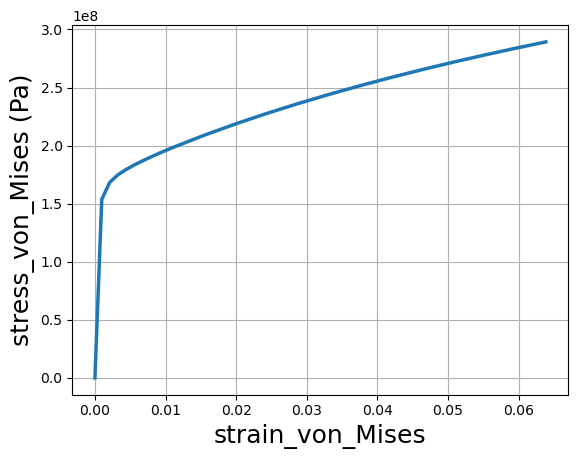

In [21]:
# Plot stress vs strain curve
job_damask.plot_stress_strain(von_mises=True)
plt.xlabel("strain_von_Mises")
plt.ylabel("stress_von_Mises (Pa)")
plt.show();

Let's compare our damask simulated stress-strain curve with the experimental curve

In [22]:
# Load the experimental stress-strain data
exp_data = np.loadtxt("../resources/true_stress_strain.txt")

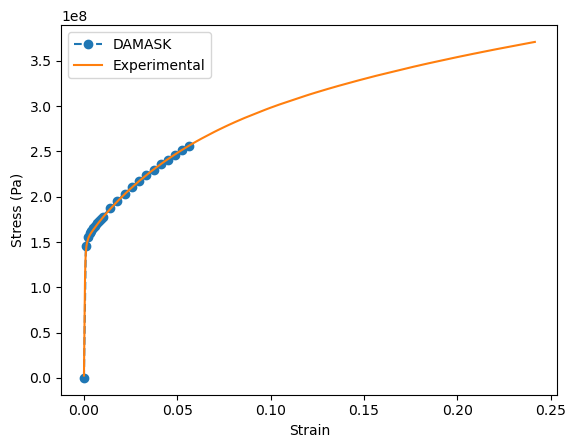

In [23]:
# Plot damask calculated stress-strain curve along with the experimental curve
plt.plot(job_damask.output.strain[:, 0, 0], job_damask.output.stress[:, 0, 0],
         '--o', label="DAMASK")
plt.plot(exp_data[:,1][:12000], exp_data[:,0][:12000]*MPa_to_Pa, label="Experimental")
plt.xlabel("Strain")
plt.ylabel("Stress (Pa)")
plt.legend()
plt.show();

### <font style="font-family:roboto;color:#455e6c"> Run DAMASK simulation with LAMMPS calculated elastic parameters </font>

Let's create two python functions to make our life easier
- A first python function which takes any bulk structure and corresponding potential file name as input and calculate the elastic tensors with `LAMMPS`
- A second python function which takes the elastic tensors from the first python function as input and perform a tensile test simulation with `DAMASK`

In [24]:
# A python function to run LAMMPS
def calc_elastic_tensors_lammps(structure, 
                                potential="2005--Mendelev-M-I--Al-Fe--LAMMPS--ipr1",
                                delete_existing_job=False
                               ):
    """
    This function takes atomic structure as input argument and returns
    elastic tensor values for the structure.
    """
    # Create and optimizate the structure
    job_mini = pr.create.job.Lammps(job_name='lammps_mini_job',
                                    delete_existing_job=delete_existing_job)
    job_mini.structure = structure
    job_mini.potential = potential
    job_mini.calc_static()
    job_mini.run()
    
    # Create a reference job 
    job_ref = pr.create.job.Lammps(job_name='lammps_ref_job',
                                   delete_existing_job=delete_existing_job)
    job_ref.structure = job_mini.get_structure(-1) # Assign the already optimized structure to this job
    job_ref.potential = potential
    job_ref.calc_static()
    
    # Create a `ElasticTensor` job and assign `job_ref` to this job
    job_elastic = pr.create.job.ElasticTensor(job_name="elastic_tensor_job",
                                              delete_existing_job=delete_existing_job)
    job_elastic.ref_job = job_ref
    
    # Call the run function
    job_elastic.run()
    
    output = {"type": "Hooke",
              "C_11": job_elastic['output/elastic_tensor'][0][0]*GPa_to_Pa,
              "C_12": job_elastic['output/elastic_tensor'][0][1]*GPa_to_Pa,
              "C_44": job_elastic['output/elastic_tensor'][3][3]*GPa_to_Pa}
    
    return output

In [25]:
# A python function to run DAMASK
def run_damask_simulation(elasticity_data, 
                          plasticity_data,
                          delete_existing_job=False):
    """
    This function takes elastic tensors as input argument and returns
    strain and stress values of damask tensile simulation.
    """
    # Create a damask job
    job_damask = pr.create.job.DAMASK("damask_simulation_lammps", 
                                      delete_existing_job=delete_existing_job)
    
    # Elastic paramaters of the material
    elasticity = pr.continuum.damask.Elasticity(**elasticity_data)
    
    # Plastic parameters of the material
    plasticity = pr.continuum.damask.Plasticity(**plasticity_data)
    
    # Define phase of the material
    phase = pr.continuum.damask.Phase(composition ='DX56D',
                                      lattice = 'cI',
                                      output_list = ['F', 'P'],
                                      elasticity = elasticity, 
                                      plasticity = plasticity
                                     )
    # Define homogenization
    homogenization = pr.continuum.damask.Homogenization(method='SX',
                                                        parameters={'N_constituents': 1,
                                                                    "mechanical": {"type": "pass"}})
    # Defines the number of grains and grids
    grains = 60
    grids = 16 
    
    # Define homogenization
    rotation = pr.continuum.damask.Rotation(Rotation.from_random,
                                            grains)
    # Materialpoint configuration
    material = pr.continuum.damask.Material([rotation],
                                            ['DX56D'],
                                            phase,
                                            homogenization)
    # Define grid
    grid = pr.continuum.damask.Grid.via_voronoi_tessellation(spatial_discretization=grids,
                                                             num_grains=grains,
                                                             box_size=1.6e-5)
    
    # Assign the material and grid to the damask job
    job_damask.material = material
    job_damask.grid = grid
    
    # Generate a load case for the grid solver
    load_step =[{'mech_bc_dict' : 
                 {'dot_F' : [1e-3, 0, 0,
                             0, 'x', 0,
                             0, 0, 'x'],
                  'P' : ['x', 'x', 'x',
                         'x', 0, 'x',
                         'x', 'x', 0]
                  },
                 'discretization' : {'t' : 10., 'N' : 40},
                 'additional': {'f_out' : 4}
                 },
                {'mech_bc_dict' : 
                 {'dot_F' : [1e-3, 0, 0,
                             0, 'x', 0,
                             0, 0, 'x'],
                  'P':['x', 'x', 'x',
                       'x', 0, 'x',
                       'x', 'x', 0]
                 },
                 'discretization' : {'t' : 50., 'N' : 50}, # Use t=250. and N=250
                 'additional': {'f_out' : 4}
                 }]
    
    # Assign solver and load step to the damask job
    job_damask.loading = pr.continuum.damask.Loading(solver=job_damask.list_solvers()[0],
                                                     load_steps=load_step
                                                     )
    
    # Run the simulation
    job_damask.run()

    return job_damask.output.strain[:, 0, 0], job_damask.output.stress[:, 0, 0]

#### <font style="font-family:roboto;color:#455e6c"> We will use the python functions defined above to perform our simulation </font>

First, create a cubic unit cell of bcc iron and use `calc_elastic_tensors_lammps()` to calculate the elastic tensors 

In [26]:
# Complete the code below to create a atomic structure of bcc iron
my_structure = pr.create.structure.bulk("Fe", cubic=True)

Pass `my_structure` to `calc_elastic_tensors_lammps()`

In [27]:
# Calculate elastic tensors
elasticity_data = calc_elastic_tensors_lammps(structure=my_structure)

The job lammps_mini_job was saved and received the ID: 28
The job elastic_tensor_job was saved and received the ID: 29
The job elastic_tensor_job_0 was saved and received the ID: 30
The job elastic_tensor_job_1 was saved and received the ID: 31
The job elastic_tensor_job_2 was saved and received the ID: 32
The job elastic_tensor_job_3 was saved and received the ID: 33
The job elastic_tensor_job_4 was saved and received the ID: 34
The job elastic_tensor_job_5 was saved and received the ID: 35
The job elastic_tensor_job_6 was saved and received the ID: 36
The job elastic_tensor_job_7 was saved and received the ID: 37
The job elastic_tensor_job_8 was saved and received the ID: 38
The job elastic_tensor_job_9 was saved and received the ID: 39
The job elastic_tensor_job_10 was saved and received the ID: 40
The job elastic_tensor_job_11 was saved and received the ID: 41
The job elastic_tensor_job_12 was saved and received the ID: 42
The job elastic_tensor_job_13 was saved and received the ID

In [28]:
# Set plasticity parameters of the material
plasticity_data = {"type": "phenopowerlaw",
                   "references": ["https://doi.org/10.1016/j.actamat.2014.07.071",
                                   "https://doi.org/10.1007/BF02900224"],
                   "output": ["xi_sl", "gamma_sl"],
                   "N_sl": [12, 12],
                   "dot_gamma_0_sl": [0.001, 0.001],
                   "n_sl": [20, 20],
                   "a_sl": [3.3838750211834414, 2.71513775941709],
                   "xi_0_sl": [58854884.55400854, 116398683.46869445],
                   "xi_inf_sl": [245397260.8849832, 289183253.8512693],
                   "h_0_sl_sl": [839702224.3104236, 797832430.2007155],
                   "h_sl_sl": [1, 1.4, 1, 1.4, 1.4, 1.4, 1.4, 1.4,
                                1.4,1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4,
                                1.4,1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4]
                   }

Pass the `elasticity_data` and `elasticity_data` to `run_damask_simulation()`

In [29]:
# Execute this cell to get damask calculated stress and strain
result = run_damask_simulation(elasticity_data, plasticity_data)

The job damask_simulation_lammps was saved and received the ID: 53


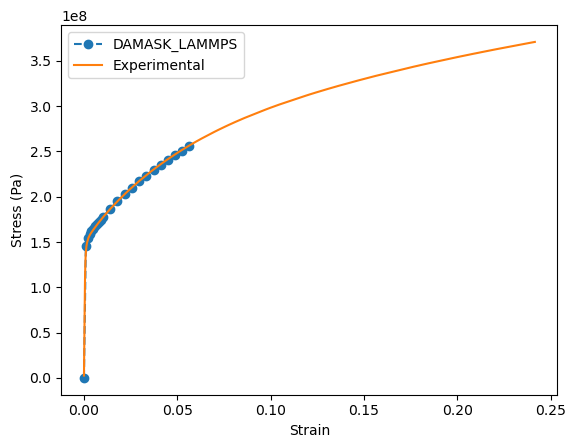

In [30]:
# Plot damask calculated stress-strain curve along with the experimental curve
plt.plot(result[0], result[1], '--o', label="DAMASK_LAMMPS")
plt.plot(exp_data[:,1][:12000], exp_data[:,0][:12000]*MPa_to_Pa, label="Experimental")
plt.xlabel("Strain")
plt.ylabel("Stress (Pa)")
plt.legend()
plt.show();

### <font style="font-family:roboto;color:#455e6c"> Software used in this notebook </font>

- [pyiron_atomistics](https://github.com/pyiron/pyiron_atomistics)
- [pyiron_continuum](https://github.com/pyiron/pyiron_continuum)
- [LAMMPS](https://www.lammps.org/)
- [DAMASK](https://damask.mpie.de/release)